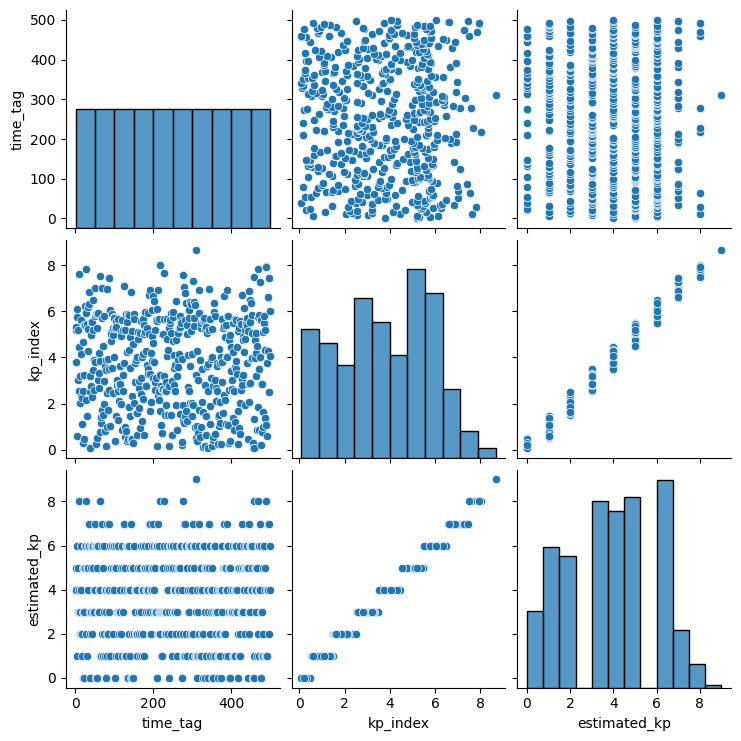

In [2]:
import seaborn as sns
import pandas as pd

data = pd.read_csv("kp_index_prediction_test3000.csv")
#data2 = pd.read_csv("dscovr_mag_1s.csv")

sns.pairplot(data)


In [3]:
data.head()

,time_tag,kp_index,estimated_kp
0,1,5.21,5
1,2,3.79,4
2,3,5.31,5
3,4,5.76,6
4,5,0.60,1


In [5]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

df = pd.read_csv('kp_index_prediction_test3000.csv')

# # timestamp to datetime 
# df['time_tag'] = pd.to_datetime(df['time_tag'], format='%Y-%m-%dT%H:%M:%S')

# df['time_tag'] = (df['time_tag'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

# Handle missing values 
df.fillna(df.mean(), inplace=True)

# data normalization
scaler = MinMaxScaler(feature_range=(0, 1))
df['kp_index'] = scaler.fit_transform(df['kp_index'].values.reshape(-1,1))

# time series data to supervised learning 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # i put put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # i'll then drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# No. of lag hours
n_hours = 400
n_features = 1

# Frame as supervised learning
reframed = series_to_supervised(df, n_hours, 1)

print(reframed.head())


     var1(t-400)  var2(t-400)  var3(t-400)  var1(t-399)  var2(t-399)  \
400          1.0     0.596512          5.0          2.0     0.431395   
401          2.0     0.431395          4.0          3.0     0.608140   
402          3.0     0.608140          5.0          4.0     0.660465   
403          4.0     0.660465          6.0          5.0     0.060465   
404          5.0     0.060465          1.0          6.0     0.701163   

     var3(t-399)  var1(t-398)  var2(t-398)  var3(t-398)  var1(t-397)  ...  \
400          4.0          3.0     0.608140          5.0          4.0  ...   
401          5.0          4.0     0.660465          6.0          5.0  ...   
402          6.0          5.0     0.060465          1.0          6.0  ...   
403          1.0          6.0     0.701163          6.0          7.0  ...   
404          6.0          7.0     0.595349          5.0          8.0  ...   

     var3(t-3)  var1(t-2)  var2(t-2)  var3(t-2)  var1(t-1)  var2(t-1)  \
400        5.0      399.0   0.3

In [6]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import matplotlib.pyplot as plt

df = pd.read_csv('kp_index_prediction_test3000.csv')

# df['time_tag'] = pd.to_datetime(df['time_tag'], format='%Y-%m-%dT%H:%M:%S')

# # Convert timestamp to the no. of secs
# df['time_tag'] = (df['time_tag'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

df.fillna(df.mean(), inplace=True)

scaler = MinMaxScaler(feature_range=(0, 1))
df['kp_index'] = scaler.fit_transform(df['kp_index'].values.reshape(-1,1))

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# No. of lag hours
n_hours = 400
n_features = 1

reframed = series_to_supervised(df, n_hours, 1)

print(reframed.head())

# target variable
y = reframed['var1(t)']

# features
X = reframed.drop('var1(t)', axis=1)

# training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Training set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)
print("\n")

X_train = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(400, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))

# Compile the model
model.compile(loss='mae', optimizer='adam')

# Fit the model
history = model.fit(X_train, y_train, epochs=200, batch_size=72, validation_data=(X_test, y_test), verbose=2, shuffle=False)

# Plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

     var1(t-400)  var2(t-400)  var3(t-400)  var1(t-399)  var2(t-399)  \
400          1.0     0.596512          5.0          2.0     0.431395   
401          2.0     0.431395          4.0          3.0     0.608140   
402          3.0     0.608140          5.0          4.0     0.660465   
403          4.0     0.660465          6.0          5.0     0.060465   
404          5.0     0.060465          1.0          6.0     0.701163   

     var3(t-399)  var1(t-398)  var2(t-398)  var3(t-398)  var1(t-397)  ...  \
400          4.0          3.0     0.608140          5.0          4.0  ...   
401          5.0          4.0     0.660465          6.0          5.0  ...   
402          6.0          5.0     0.060465          1.0          6.0  ...   
403          1.0          6.0     0.701163          6.0          7.0  ...   
404          6.0          7.0     0.595349          5.0          8.0  ...   

     var3(t-3)  var1(t-2)  var2(t-2)  var3(t-2)  var1(t-1)  var2(t-1)  \
400        5.0      399.0   0.3

KeyboardInterrupt: 

In [ ]:
import sklearn.metrics
from math import sqrt
import numpy as np
from sklearn.metrics import mean_squared_error
from numpy import concatenate

# make a prediction
yhat = model.predict(X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1)))

# invert scaling for forecast
inv_yhat = concatenate((yhat, X_test.values[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
y_test = y_test.reshape((len(y_test), 1))
inv_y = concatenate((y_test, X_test.values[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

def mean_absolute_error(inv_y, inv_yhat):
    return np.mean(np.abs(inv_y - inv_yhat ))
mae = mean_absolute_error(inv_y,inv_yhat )
print(f"Mean Absolute Error: {mae}")





1/1 [==============================] - 0s 386ms/step
Test RMSE: 0.042
Mean Absolute Error: 0.0397239000047557


12/12 [==============================] - 0s 8ms/step
[[-0.00363138]
 [ 0.00230013]
 [ 0.00831578]
 [ 0.01438979]
 [ 0.0204976 ]
 [ 0.02661596]
 [ 0.03272276]
 [ 0.03879736]
 [ 0.0448207 ]
 [ 0.05077501]
 [ 0.05664402]
 [ 0.06241297]
 [ 0.06806862]
 [ 0.0735989 ]
 [ 0.07899345]
 [ 0.0842428 ]
 [ 0.08933905]
 [ 0.0942755 ]
 [ 0.09904657]
 [ 0.10364767]
 [ 0.10807535]
 [ 0.11232724]
 [ 0.11640161]
 [ 0.12029774]
 [ 0.12401565]
 [ 0.12755609]
 [ 0.13092044]
 [ 0.13411073]
 [ 0.1371292 ]
 [ 0.13997883]
 [ 0.1426633 ]
 [ 0.14518598]
 [ 0.14755078]
 [ 0.14976218]
 [ 0.15182453]
 [ 0.15374231]
 [ 0.15552041]
 [ 0.1571635 ]
 [ 0.15867674]
 [ 0.16006482]
 [ 0.1613327 ]
 [ 0.16248557]
 [ 0.16352786]
 [ 0.1644647 ]
 [ 0.16530077]
 [ 0.16604067]
 [ 0.16668922]
 [ 0.16725063]
 [ 0.16772957]
 [ 0.16812983]
 [ 0.1684561 ]
 [ 0.16871195]
 [-0.04577369]
 [-0.04138508]
 [-0.03670906]
 [-0.0317661 ]
 [-0.0265791 ]
 [-0.02117336]
 [-0.01557535]
 [-0.00981276]
 [-0.00391308]
 [ 0.00209621]
 [ 0.00818806]
 [

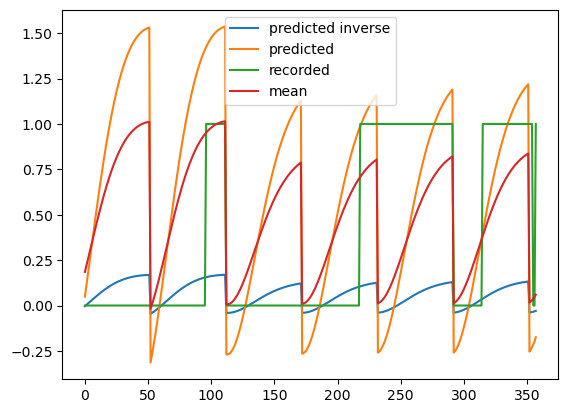

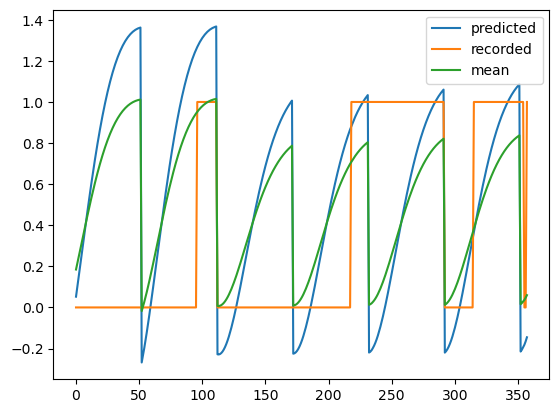

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df_new=pd.read_csv("planetary_k_index_1m.csv")

# df_new['time_tag'] = pd.to_datetime(df_new['time_tag'])

# # freaturer creaation
# df_new['year'] = df_new['time_tag'].dt.year
# df_new['month'] = df_new['time_tag'].dt.month
# df_new['day'] = df_new['time_tag'].dt.day
# df_new['hour'] = df_new['time_tag'].dt.hour
# df_new['minute'] = df_new['time_tag'].dt.minute

# df_new = df_new.drop('time_tag', axis=1)

# Convert the DataFrame to numpy array to convert to float to reshape to 3D
new_data = df_new.values.astype('float32').reshape((df_new.shape[0], df_new.shape[1], 1))

# making prediction
new_yhat = model.predict(new_data)

# Inverting for forecasting 
inv_new_yhat = scaler.inverse_transform(new_yhat)
print(new_yhat,inv_new_yhat)

plt.plot(new_yhat, label='predicted inverse')
plt.plot(inv_new_yhat, label='predicted')
plt.plot(df_new['kp_index'], label='recorded')
plt.plot((inv_new_yhat+new_yhat)/2+0.162, label='mean')
plt.legend()
plt.show()

plt.plot(inv_new_yhat-new_yhat, label='predicted')
plt.plot(df_new['kp_index'], label='recorded')
plt.plot(((inv_new_yhat+new_yhat)/2)+0.162, label='mean')
plt.legend()
plt.show()



1/1 [==============================] - 0s 40ms/step
[[ 2.5339003e-03]
 [ 2.8619790e-03]
 [ 2.0632546e-03]
 [ 6.2077101e-03]
 [ 1.2063484e-03]
 [ 5.3325323e-03]
 [ 1.2975431e-02]
 [ 1.2590751e-02]
 [ 7.1320566e-04]
 [-1.5280724e-03]
 [-3.3326561e-03]
 [-4.0223366e-03]
 [-1.4670310e-04]
 [-8.0031576e-05]
 [ 6.0414830e-03]
 [ 9.6710762e-03]
 [ 1.0102334e-02]
 [ 1.9663176e-02]
 [ 2.0009423e-02]
 [-1.0925454e-02]
 [-6.3052746e-03]
 [-1.5135971e-02]
 [-1.6762311e-02]
 [-1.2633280e-02]
 [-5.5475859e-03]
 [-5.2342685e-03]
 [ 3.8824554e-03]
 [ 3.6597427e-03]
 [ 9.3025481e-03]
 [ 2.0351075e-02]] [[ 0.10179155]
 [ 0.10461302]
 [ 0.09774399]
 [ 0.13338631]
 [ 0.0903746 ]
 [ 0.12585978]
 [ 0.19158871]
 [ 0.18828046]
 [ 0.08613357]
 [ 0.06685858]
 [ 0.05133916]
 [ 0.04540791]
 [ 0.07873835]
 [ 0.07931173]
 [ 0.13195676]
 [ 0.16317126]
 [ 0.16688009]
 [ 0.24910331]
 [ 0.25208104]
 [-0.01395891]
 [ 0.02577464]
 [-0.05016935]
 [-0.06415587]
 [-0.02864621]
 [ 0.03229076]
 [ 0.03498529]
 [ 0.11338912]
 [

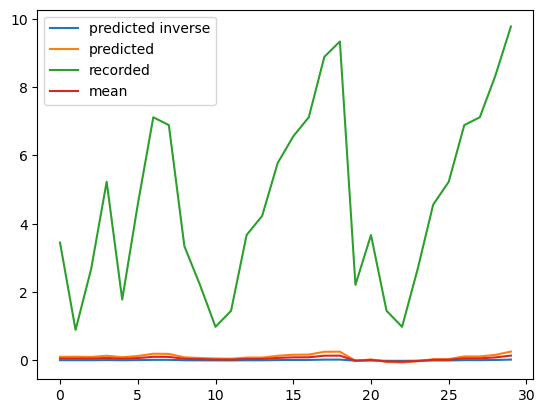

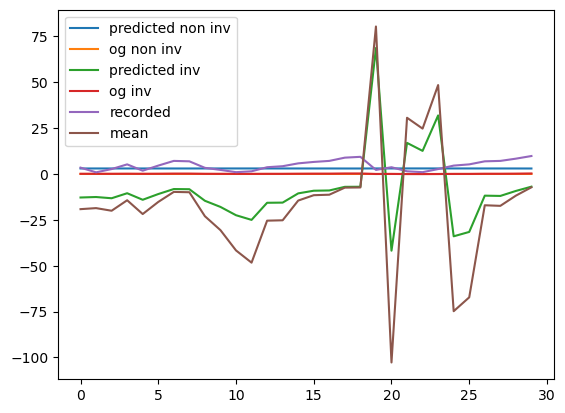

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df_new=pd.read_csv("fabric _true.csv")

# Convert the DataFrame to numpy array to convert to float to reshape to 3D
new_data = df_new.values.astype('float32').reshape((df_new.shape[0], df_new.shape[1], 1))

# making prediction
new_yhat = model.predict(new_data)

# Inverting for forecasting 
inv_new_yhat = scaler.inverse_transform(new_yhat)
print(new_yhat,inv_new_yhat)

plt.plot(new_yhat, label='predicted inverse')
plt.plot(inv_new_yhat, label='predicted')
plt.plot(df_new['kp_index'], label='recorded')
plt.plot((inv_new_yhat+new_yhat)/2, label='mean')
plt.legend()
plt.show()

plt.plot(-new_yhat+3, label='predicted non inv')
plt.plot(new_yhat, label='og non inv')
plt.plot(-1/inv_new_yhat-3, label='predicted inv')
plt.plot(inv_new_yhat, label='og inv')
plt.plot(df_new['kp_index'], label='recorded')
plt.plot(-1/((inv_new_yhat+new_yhat)/2), label='mean')
plt.legend()
plt.show()





12/12 [==============================] - 0s 4ms/step
[[ 0.00367899]
 [ 0.00343869]
 [ 0.00306489]
 [ 0.00257181]
 [ 0.0019729 ]
 [ 0.00128065]
 [ 0.00050651]
 [-0.00033917]
 [-0.00124707]
 [-0.00220889]
 [-0.0032172 ]
 [-0.00426548]
 [-0.00534779]
 [-0.00645892]
 [-0.0075329 ]
 [-0.00864993]
 [-0.00978375]
 [-0.01093055]
 [-0.0120868 ]
 [-0.01324912]
 [-0.01441438]
 [-0.01557954]
 [-0.01674179]
 [-0.01826014]
 [-0.01904699]
 [-0.02018505]
 [-0.02175523]
 [-0.02289201]
 [-0.02401138]
 [-0.02511172]
 [-0.02619147]
 [-0.02724933]
 [-0.02828403]
 [-0.02929453]
 [-0.03027995]
 [-0.0312395 ]
 [-0.03150107]
 [-0.03238829]
 [-0.03324882]
 [-0.03408231]
 [-0.0348886 ]
 [-0.03566758]
 [-0.03641923]
 [-0.03714368]
 [-0.03784107]
 [-0.03851161]
 [-0.0391556 ]
 [-0.03977334]
 [-0.04036523]
 [-0.04093166]
 [-0.0414731 ]
 [-0.04199004]
 [-0.04248305]
 [-0.04295255]
 [-0.04339919]
 [-0.04382351]
 [-0.04422612]
 [-0.04460751]
 [-0.04496841]
 [-0.04530933]
 [-0.0456309 ]
 [-0.04593371]
 [-0.04621833]
 [

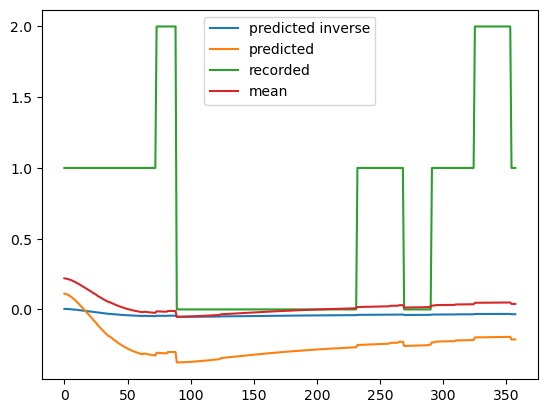

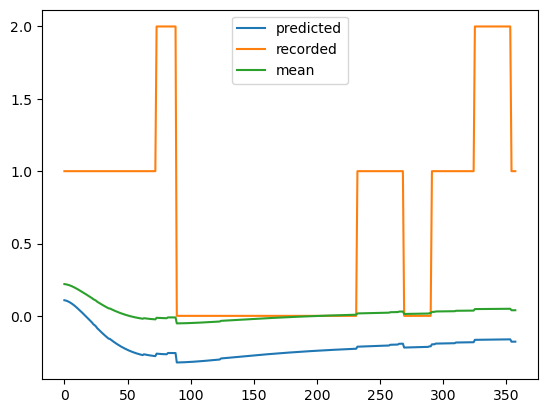

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df_new=pd.read_csv("planetary_k_index_1m.csv")

# df_new['time_tag'] = pd.to_datetime(df_new['time_tag'])

# # freaturer creaation
# df_new['year'] = df_new['time_tag'].dt.year
# df_new['month'] = df_new['time_tag'].dt.month
# df_new['day'] = df_new['time_tag'].dt.day
# df_new['hour'] = df_new['time_tag'].dt.hour
# df_new['minute'] = df_new['time_tag'].dt.minute

# df_new = df_new.drop('time_tag', axis=1)

# Convert the DataFrame to numpy array to convert to float to reshape to 3D
new_data = df_new.values.astype('float32').reshape((df_new.shape[0], df_new.shape[1], 1))

# making prediction
new_yhat = model.predict(new_data)

# Inverting for forecasting 
inv_new_yhat = scaler.inverse_transform(new_yhat)
print(new_yhat,inv_new_yhat)

plt.plot(new_yhat, label='predicted inverse')
plt.plot(inv_new_yhat, label='predicted')
plt.plot(df_new['kp_index'], label='recorded')
plt.plot((inv_new_yhat+new_yhat)/2+0.162, label='mean')
plt.legend()
plt.show()

plt.plot(inv_new_yhat-new_yhat, label='predicted')
plt.plot(df_new['kp_index'], label='recorded')
plt.plot(((inv_new_yhat+new_yhat)/2)+0.162, label='mean')
plt.legend()
plt.show()